In [1]:
import os
import re
import pandas as pd
import numpy as np
import librosa
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    Wav2Vec2Model, Wav2Vec2Processor,
    WhisperModel, WhisperProcessor, 
    BertModel, BertTokenizer,
    AutoModel, AutoTokenizer
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.stats import ks_2samp
import scipy.linalg
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

2025-11-14 03:20:29.751116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763090429.966829      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763090430.029023      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
@dataclass
class ADReSSConfig:
    """Configuration class for ADReSS dataset processing."""
    # train_path: str = "ADReSS-IS2020-train/ADReSS-IS2020-data/train"
    train_path: str = "/kaggle/input/adress/adress/train"
    # test_path: str = "ADReSS-IS2020-test/ADReSS-IS2020-data/test"
    test_path: str = "/kaggle/input/adress/adress/test"
    audio_sr: int = 16000
    
    # Audio feature extraction parameters
    n_mfcc: int = 13
    n_mel: int = 128
    hop_length: int = 512
    n_fft: int = 2048
    
    # Feature statistics windows
    statistical_windows: List[str] = None
    
    def __post_init__(self):
        if self.statistical_windows is None:
            self.statistical_windows = ['mean', 'std', 'min', 'max', 'median']

In [3]:
class MetadataLoader:
    """Handles loading and processing of metadata files for both training and test datasets."""
    
    def __init__(self, base_path: str):
        self.base_path = Path(base_path)
        self.dataset_type = self._detect_dataset_type()
    
    def _detect_dataset_type(self) -> str:
        """Detect if this is training data or test data based on file structure."""
        cc_path = self.base_path / "cc_meta_data.txt"
        cd_path = self.base_path / "cd_meta_data.txt"
        test_path = self.base_path / "meta_data.txt"
        
        if cc_path.exists() and cd_path.exists():
            return "training"
        elif test_path.exists():
            return "test"
        else:
            raise FileNotFoundError("Could not detect dataset type. Expected either training files (cc_meta_data.txt, cd_meta_data.txt) or test file (meta_data.txt)")
    
    def load_metadata(self) -> pd.DataFrame:
        """Load metadata from either training or test dataset."""
        if self.dataset_type == "training":
            return self._load_training_metadata()
        else:
            return self._load_test_metadata()
    
    def _load_training_metadata(self) -> pd.DataFrame:
        """Load metadata from both control and dementia groups."""
        print("Loading training metadata...")
        cc_path = self.base_path / "cc_meta_data.txt"
        cd_path = self.base_path / "cd_meta_data.txt"
        
        cc_df = pd.read_csv(cc_path, sep=';', skipinitialspace=True)
        cd_df = pd.read_csv(cd_path, sep=';', skipinitialspace=True)
        
        # Clean column names by stripping whitespace
        cc_df.columns = cc_df.columns.str.strip()
        cd_df.columns = cd_df.columns.str.strip()
        
        cc_df['label'] = 0  # Control
        cd_df['label'] = 1  # Dementia
        cc_df['group'] = 'cc'
        cd_df['group'] = 'cd'
        
        print("Processing metadata...")
        metadata = pd.concat([cc_df, cd_df], ignore_index=True)
        
        # Process IDs and MMSE
        metadata['ID'] = metadata['ID'].str.strip()
        metadata['mmse'] = pd.to_numeric(metadata['mmse'], errors='coerce')
        
        print(f"Loaded {len(metadata)} subjects ({len(cc_df)} control, {len(cd_df)} dementia)")
        return metadata
    
    def _load_test_metadata(self) -> pd.DataFrame:
        """Load test metadata (no labels, different format)."""
        print("Loading test metadata...")
        meta_path = self.base_path / "meta_data.txt"
        
        # Read test metadata - format: ID ; age ; gender
        test_df = pd.read_csv(meta_path, sep=';', skipinitialspace=True, header=None)
        test_df.columns = ['ID', 'age', 'gender']
        
        print("Processing test metadata...")
        # Clean column data
        test_df['ID'] = test_df['ID'].str.strip()
        test_df['age'] = pd.to_numeric(test_df['age'], errors='coerce')
        test_df['gender'] = test_df['gender'].str.strip()
        
        # Test data has no labels or MMSE scores
        test_df['label'] = -1  # Unknown label for test data
        test_df['mmse'] = np.nan  # No MMSE scores in test data
        test_df['group'] = 'test'
        
        print(f"Loaded {len(test_df)} test subjects")
        return test_df

In [4]:
class TranscriptionProcessor:
    """Processes CHAT format transcription files."""
    
    def __init__(self):
        self.participant_pattern = re.compile(r'\*PAR:\s*(.*?)\s*(\d+)_(\d+)')
        self.investigator_pattern = re.compile(r'\*INV:\s*(.*?)\s*(\d+)_(\d+)')
        
    def extract_speech_with_timing(self, file_path: str) -> Dict:
        """Extract participant and investigator speech with timestamps."""
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        participant_utterances = []
        investigator_utterances = []
        participant_segments = []
        investigator_segments = []
        
        # Find all matches first
        par_matches = list(self.participant_pattern.finditer(content))
        inv_matches = list(self.investigator_pattern.finditer(content))
        
        # Process participant matches
        for match in par_matches:
            utterance = self._clean_utterance(match.group(1))
            start_time = int(match.group(2))
            end_time = int(match.group(3))
            if utterance:
                participant_utterances.append(utterance)
                participant_segments.append((start_time, end_time, utterance))
        
        # Process investigator matches
        for match in inv_matches:
            utterance = self._clean_utterance(match.group(1))
            start_time = int(match.group(2))
            end_time = int(match.group(3))
            if utterance:
                investigator_utterances.append(utterance)
                investigator_segments.append((start_time, end_time, utterance))
        
        return {
            'participant_text': ' '.join(participant_utterances),
            'investigator_text': ' '.join(investigator_utterances),
            'total_utterances': len(participant_utterances),
            'participant_segments': participant_segments,
            'investigator_segments': investigator_segments
        }
    
    def extract_speech(self, file_path: str) -> Dict[str, str]:
        """Backward compatibility method."""
        return self.extract_speech_with_timing(file_path)
    
    def _clean_utterance(self, utterance: str) -> str:
        """Clean CHAT annotations from utterance."""
        cleaned = re.sub(r'\[.*?\]', '', utterance)
        cleaned = re.sub(r'&\w+', '', cleaned)
        cleaned = re.sub(r'<[^>]*>', '', cleaned)
        cleaned = re.sub(r'\([^)]*\)', '', cleaned)
        cleaned = re.sub(r'\s+', ' ', cleaned)
        return cleaned.strip()

In [5]:
class AudioProcessor:
    """Processes audio chunks and extracts features."""
    
    def __init__(self, config: ADReSSConfig):
        self.config = config
    
    def load_audio_chunks(self, chunks_dir: str, subject_id: str) -> List[Dict]:
        """Load all normalized audio chunks for a subject. All chunks are participant speech."""
        chunks_path = Path(chunks_dir)
        pattern = f"{subject_id}-*.wav"
        chunk_files = list(chunks_path.glob(pattern))
        
        participant_chunks = []
        
        for chunk_file in chunk_files:
            filename = chunk_file.name
            audio, sr = librosa.load(str(chunk_file), sr=self.config.audio_sr)
            
            # Parse timing information from filename for sequencing
            # Format: S001-7-4266-13310-1-2400-3470.wav
            parts = filename.replace('.wav', '').split('-')
            start_time = None
            end_time = None
            chunk_num = None
            
            if len(parts) >= 5:
                try:
                    start_time = int(parts[2])
                    end_time = int(parts[3])
                    chunk_num = int(parts[4]) if len(parts) > 4 else 0
                except ValueError:
                    pass
            
            chunk_info = {
                'audio': audio,
                'sr': sr,
                'filename': filename,
                'file_path': str(chunk_file),
                'start_time': start_time,
                'end_time': end_time,
                'chunk_num': chunk_num
            }
            participant_chunks.append(chunk_info)
        
        # Sort chunks by temporal order (start_time, then chunk_num)
        participant_chunks.sort(key=lambda x: (x['start_time'] or 0, x['chunk_num'] or 0))
        
        return participant_chunks
    
    def aggregate_chunk_features(self, chunks: List[Dict]) -> Dict[str, float]:
        """Return minimal info without handcrafted features."""
        if not chunks:
            return {}
        
        total_duration = 0
        valid_chunks = 0
        
        for chunk in chunks:
            audio = chunk['audio']
            if len(audio) > 0:  # Skip empty audio chunks
                total_duration += len(audio) / self.config.audio_sr
                valid_chunks += 1
        
        return {
            'total_duration': total_duration,
            'num_chunks': valid_chunks
        }

In [6]:
class AlignmentProcessor:
    """Handles temporal alignment between transcript and audio chunks."""
    
    def __init__(self):
        pass
    
    def align_transcript_audio(self, participant_segments: List[Tuple], 
                             participant_chunks: List[Dict]) -> List[Dict]:
        """Align transcript segments with audio chunks by timestamp overlap."""
        aligned_pairs = []
        
        # Process segments
        for seg_start, seg_end, utterance in participant_segments:
            for chunk in participant_chunks:
                chunk_start = chunk.get('start_time')
                chunk_end = chunk.get('end_time')
                
                if chunk_start is None or chunk_end is None:
                    continue
                
                # Check for overlap
                if not (seg_end <= chunk_start or seg_start >= chunk_end):
                    aligned_pairs.append({
                        'text': utterance,
                        'audio_file': chunk['filename'],
                        'text_start': seg_start,
                        'text_end': seg_end,
                        'audio_start': chunk_start,
                        'audio_end': chunk_end,
                        'audio_data': chunk['audio']
                    })
        
        return aligned_pairs

In [7]:
class ADReSSDataLoader:
    """Main data loader class that orchestrates all preprocessing components for both training and test data."""
    
    def __init__(self, base_path: str, config: Optional[ADReSSConfig] = None):
        self.base_path = Path(base_path)
        self.config = config or ADReSSConfig()
        
        self.metadata_loader = MetadataLoader(self.base_path)
        self.transcription_processor = TranscriptionProcessor()
        self.audio_processor = AudioProcessor(self.config)
        self.alignment_processor = AlignmentProcessor()
        
        # Detect dataset type
        self.dataset_type = self.metadata_loader.dataset_type
        
    def load_dataset(self, 
                    use_audio_chunks: bool = True,
                    include_audio: bool = True,
                    include_text: bool = True,
                    align_modalities: bool = False) -> pd.DataFrame:
        """Load complete dataset with optional modality alignment."""
        
        metadata = self.metadata_loader.load_metadata()
        dataset_rows = []
        
        print(f"Loading {self.dataset_type} dataset...")
        if align_modalities:
            print("Note: Aligning text and audio modalities by timestamp.")
        
        for _, row in tqdm(metadata.iterrows(), desc=f"Processing {self.dataset_type} subjects", total=len(metadata)):
            subject_id = row['ID']
            group = row['group']
            
            sample_data = {
                'subject_id': subject_id,
                'age': row['age'],
                'gender': row['gender'],
                'mmse': row['mmse'],
                'label': row['label'],
                'group': group
            }
            
            # Process transcription and audio
            if align_modalities and include_text and include_audio:
                aligned_data = self._get_aligned_data(subject_id, group)
                sample_data.update(aligned_data)
            else:
                # Process transcription
                if include_text:
                    transcript_path = self._get_transcript_path(subject_id, group)
                    if transcript_path and transcript_path.exists():
                        text_data = self.transcription_processor.extract_speech_with_timing(str(transcript_path))
                        sample_data.update({k: v for k, v in text_data.items() 
                                          if k not in ['participant_segments', 'investigator_segments']})
                
                # Process audio chunks
                if include_audio and use_audio_chunks:
                    chunks_dir = self._get_chunks_directory(group)
                    if chunks_dir and chunks_dir.exists():
                        try:
                            participant_chunks = self.audio_processor.load_audio_chunks(
                                str(chunks_dir), subject_id
                            )
                            
                            if participant_chunks:
                                basic_audio_info = self.audio_processor.aggregate_chunk_features(participant_chunks)
                                for key, value in basic_audio_info.items():
                                    sample_data[f'participant_{key}'] = value
                            
                            sample_data['total_participant_chunks'] = len(participant_chunks)
                            
                        except Exception as e:
                            print(f"Error processing audio chunks for {subject_id}: {e}")
                            sample_data['total_participant_chunks'] = 0
            
            dataset_rows.append(sample_data)
        
        return pd.DataFrame(dataset_rows)
    
    def _get_aligned_data(self, subject_id: str, group: str) -> Dict:
        """Get aligned text-audio pairs for a subject."""
        # Get transcript segments
        transcript_path = self._get_transcript_path(subject_id, group)
        if not transcript_path or not transcript_path.exists():
            return {}
        
        text_data = self.transcription_processor.extract_speech_with_timing(str(transcript_path))
        participant_segments = text_data['participant_segments']
        
        # Get audio chunks
        chunks_dir = self._get_chunks_directory(group)
        if not chunks_dir or not chunks_dir.exists():
            return {}
        
        participant_chunks = self.audio_processor.load_audio_chunks(str(chunks_dir), subject_id)
        
        # Use AlignmentProcessor to align segments with chunks
        aligned_pairs = self.alignment_processor.align_transcript_audio(
            participant_segments, participant_chunks
        )
        
        return {
            'participant_text': text_data['participant_text'],
            'investigator_text': text_data['investigator_text'],
            'total_utterances': text_data['total_utterances'],
            'aligned_pairs': aligned_pairs,
            'num_aligned_pairs': len(aligned_pairs)
        }
    
    def _get_transcript_path(self, subject_id: str, group: str) -> Optional[Path]:
        """Get transcript path based on dataset type."""
        if self.dataset_type == "training":
            return self.base_path / "transcription" / group / f"{subject_id}.cha"
        else:
            return self.base_path / "transcription" / f"{subject_id}.cha"
    
    def _get_chunks_directory(self, group: str) -> Optional[Path]:
        """Get audio chunks directory based on dataset type."""
        if self.dataset_type == "training":
            return self.base_path / "Normalised_audio-chunks" / group
        else:
            return self.base_path / "Normalised_audio-chunks"
    
    def get_subject_chunks(self, subject_id: str) -> Dict:
        """Get detailed chunk data for a specific subject."""
        metadata = self.metadata_loader.load_metadata()
        subject_meta = metadata[metadata['ID'] == subject_id].iloc[0]
        
        group = subject_meta['group']
        
        # Load transcription with timing
        transcript_path = self._get_transcript_path(subject_id, group)
        transcript_data = {}
        if transcript_path and transcript_path.exists():
            transcript_data = self.transcription_processor.extract_speech_with_timing(str(transcript_path))
        
        # Load audio chunks
        chunks_dir = self._get_chunks_directory(group)
        participant_chunks = []
        if chunks_dir and chunks_dir.exists():
            participant_chunks = self.audio_processor.load_audio_chunks(str(chunks_dir), subject_id)
        
        return {
            'metadata': subject_meta.to_dict(),
            'transcription': transcript_data,
            'participant_chunks': participant_chunks,
            'chunks_dir': str(chunks_dir) if chunks_dir else None,
            'transcript_path': str(transcript_path) if transcript_path else None,
            'dataset_type': self.dataset_type
        }
    
    def get_aligned_pairs(self, subject_id: str) -> List[Dict]:
        """Get aligned text-audio pairs for a specific subject."""
        metadata = self.metadata_loader.load_metadata()
        subject_meta = metadata[metadata['ID'] == subject_id].iloc[0]
        group = subject_meta['group']
        
        aligned_data = self._get_aligned_data(subject_id, group)
        return aligned_data.get('aligned_pairs', [])

In [8]:
class AudioEmbedder:
    def __init__(self, model_type='wav2vec2', device='cuda'):
        self.model_type = model_type
        self.device = device
        
        if model_type == 'wav2vec2':
            self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
            self.model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base").to(device)
        elif model_type == 'whisper':
            self.processor = WhisperProcessor.from_pretrained("openai/whisper-small")
            self.model = WhisperModel.from_pretrained("openai/whisper-small").to(device)
        
        self.model.eval()
        
    def extract_embeddings(self, audio_chunks):
        embeddings = []
        
        for i, chunk in enumerate(audio_chunks):
            audio = chunk['audio']
            
            try:
                if self.model_type == 'wav2vec2':
                    inputs = self.processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
                    inputs = {k: v.to(self.device) for k, v in inputs.items()}
                    
                    with torch.no_grad():
                        outputs = self.model(**inputs)
                        embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                elif self.model_type == 'whisper':
                    inputs = self.processor(audio, sampling_rate=16000, return_tensors="pt")
                    inputs = {k: v.to(self.device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
                    
                    with torch.no_grad():
                        outputs = self.model.encoder(**inputs)
                        embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                        
                embeddings.append(embedding[0])
                
            except Exception as e:
                print(f"Error processing chunk: {e}")
                embeddings.append(np.zeros(768))
                
        return np.array(embeddings)

class TextEmbedder:
    def __init__(self, model_type='clinicalbert', device='cuda'):
        self.model_type = model_type
        self.device = device
        
        if model_type == 'clinicalbert':
            model_name = "emilyalsentzer/Bio_ClinicalBERT"
        elif model_type == 'biobert':
            model_name = "dmis-lab/biobert-v1.1"
        else:
            model_name = "bert-base-uncased"
            
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.model.eval()
        
    def extract_embeddings(self, texts):
        embeddings = []
        
        for i, text in enumerate(texts):
            try:
                inputs = self.tokenizer(text, return_tensors="pt", padding=True, 
                                      truncation=True, max_length=512)
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                with torch.no_grad():
                    outputs = self.model(**inputs)
                    embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
                    
                embeddings.append(embedding[0])
                
            except Exception as e:
                print(f"Error processing text: {e}")
                embeddings.append(np.zeros(768))
                
        return np.array(embeddings)

In [9]:
class MultimodalFusion(nn.Module):
    def __init__(self, audio_dim=768, text_dim=768, fusion_type='concat', output_dim=512, num_heads=8):
        super().__init__()
        self.fusion_type = fusion_type
        self.output_dim = output_dim
        
        if fusion_type == 'concat':
            self.fusion_layer = nn.Linear(audio_dim + text_dim, output_dim)
        elif fusion_type == 'cross_attention':
            self.audio_proj = nn.Linear(audio_dim, output_dim)
            self.text_proj = nn.Linear(text_dim, output_dim)
            self.cross_attn = nn.MultiheadAttention(output_dim, num_heads=num_heads, batch_first=True)
            self.norm = nn.LayerNorm(output_dim)
            self.fusion_layer = nn.Linear(output_dim * 2, output_dim)
        
    def forward(self, audio_emb, text_emb):
        if self.fusion_type == 'concat':
            combined = torch.cat([audio_emb, text_emb], dim=-1)
            return self.fusion_layer(combined)
        
        elif self.fusion_type == 'cross_attention':
            audio_proj = self.audio_proj(audio_emb).unsqueeze(1)
            text_proj = self.text_proj(text_emb).unsqueeze(1)
            
            audio_attended, _ = self.cross_attn(audio_proj, text_proj, text_proj)
            text_attended, _ = self.cross_attn(text_proj, audio_proj, audio_proj)
            
            audio_attended = self.norm(audio_attended.squeeze(1))
            text_attended = self.norm(text_attended.squeeze(1))
            
            combined = torch.cat([audio_attended, text_attended], dim=-1)
            return self.fusion_layer(combined)

class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=512, latent_dim=64, condition_dim=18, beta=4.0):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.beta = beta
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
        
    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=-1))
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=-1))
    
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, c)
        return recon, mu, logvar
    
    def loss_function(self, recon, x, mu, logvar):
        recon_loss = F.mse_loss(recon, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.beta * kl_div
    
    def generate(self, c, num_samples=1):
        z = torch.randn(num_samples, self.latent_dim).to(c.device)
        return self.decode(z, c)

class NormalizingFlow(nn.Module):
    def __init__(self, input_dim=512, condition_dim=18, num_layers=6):
        super().__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.num_layers = num_layers
        
        self.layers = nn.ModuleList([
            AffineCouplingLayer(input_dim, condition_dim, i % 2) 
            for i in range(num_layers)
        ])
        
    def forward(self, x, c):
        log_det_sum = 0
        for layer in self.layers:
            x, log_det = layer(x, c)
            log_det_sum += log_det
        return x, log_det_sum
    
    def inverse(self, z, c):
        for layer in reversed(self.layers):
            z = layer.inverse(z, c)
        return z
    
    def generate(self, c, num_samples=1):
        batch_size = c.shape[0] if len(c.shape) > 1 else 1
        z = torch.randn(batch_size, self.input_dim).to(c.device)
        return self.inverse(z, c)

class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, condition_dim, mask_type):
        super().__init__()
        self.input_dim = input_dim
        self.mask_type = mask_type
        
        mask = torch.zeros(input_dim)
        if mask_type == 0:
            mask[::2] = 1
        else:
            mask[1::2] = 1
        self.register_buffer('mask', mask)
        
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2 + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim // 2),
            nn.Tanh()
        )
        
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim // 2 + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim // 2)
        )
        
    def forward(self, x, c):
        batch_size = x.shape[0]
        x_masked = x * self.mask.unsqueeze(0)
        x_unmasked = x * (1 - self.mask.unsqueeze(0))
        
        masked_features = x_masked[:, self.mask.bool()]
        unmasked_features = x_unmasked[:, ~self.mask.bool()]
        
        scale_input = torch.cat([masked_features, c], dim=-1)
        translate_input = torch.cat([masked_features, c], dim=-1)
        
        s = self.scale_net(scale_input)
        t = self.translate_net(translate_input)
        
        y_unmasked = unmasked_features * torch.exp(s) + t
        
        y = x.clone()
        y[:, ~self.mask.bool()] = y_unmasked
        
        log_det = s.sum(dim=-1)
        return y, log_det
    
    def inverse(self, y, c):
        batch_size = y.shape[0]
        y_masked = y * self.mask.unsqueeze(0)
        y_unmasked = y * (1 - self.mask.unsqueeze(0))
        
        masked_features = y_masked[:, self.mask.bool()]
        unmasked_features = y_unmasked[:, ~self.mask.bool()]
        
        scale_input = torch.cat([masked_features, c], dim=-1)
        translate_input = torch.cat([masked_features, c], dim=-1)
        
        s = self.scale_net(scale_input)
        t = self.translate_net(translate_input)
        
        x_unmasked = (unmasked_features - t) * torch.exp(-s)
        
        x = y.clone()
        x[:, ~self.mask.bool()] = x_unmasked
        
        return x

class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=64, condition_dim=18, output_dim=512):
        super().__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        
        self.main = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            
            nn.Linear(512, output_dim),
            nn.Tanh()
        )
        
    def forward(self, noise, condition):
        x = torch.cat([noise, condition], dim=1)
        return self.main(x)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=512, condition_dim=18):
        super().__init__()
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        
        self.main = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        return self.main(x)

class ConditionalGAN(nn.Module):
    def __init__(self, latent_dim=64, condition_dim=18, output_dim=512):
        super().__init__()
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        self.output_dim = output_dim
        
        self.generator = ConditionalGenerator(latent_dim, condition_dim, output_dim)
        self.discriminator = ConditionalDiscriminator(output_dim, condition_dim)
        
    def generate(self, condition, num_samples=1):
        noise = torch.randn(num_samples, self.latent_dim).to(condition.device)
        with torch.no_grad():
            return self.generator(noise, condition)

In [10]:
@dataclass
class HyperparameterConfig:
    """Comprehensive hyperparameter management for the entire pipeline."""
    
    # Audio Embedding Models
    audio_wav2vec2_model: str = "facebook/wav2vec2-base"
    audio_whisper_model: str = "openai/whisper-small"
    
    # Text Embedding Models  
    text_clinicalbert_model: str = "emilyalsentzer/Bio_ClinicalBERT"
    text_biobert_model: str = "dmis-lab/biobert-v1.1"
    text_bert_model: str = "bert-base-uncased"
    
    # Embedding dimensions (model-specific defaults)
    audio_embedding_dim: int = 768
    text_embedding_dim: int = 768
    
    # Fusion parameters
    fusion_output_dim: int = 256
    fusion_num_heads: int = 4  # For cross-attention
    
    # Conditional VAE parameters
    vae_latent_dim: int = 64
    vae_beta: float = 4.0
    vae_hidden_dims: List[int] = None
    vae_epochs: int = 150
    vae_lr: float = 2e-3
    vae_batch_size: int = 32
    
    # Normalizing Flow parameters
    flow_num_layers: int = 6
    flow_epochs: int = 120
    flow_lr: float = 2e-3
    flow_batch_size: int = 32
    
    # Conditional GAN parameters
    gan_latent_dim: int = 64
    gan_generator_dims: List[int] = None
    gan_discriminator_dims: List[int] = None
    gan_epochs: int = 200
    gan_lr_g: float = 3e-4
    gan_lr_d: float = 3e-4
    gan_beta1: float = 0.5
    gan_beta2: float = 0.999
    gan_batch_size: int = 64
    gan_label_smoothing: float = 0.1
    
    # SVM parameters
    svm_kernel: str = 'rbf'
    svm_C: float = 2.0
    svm_gamma: str = 'scale'
    svm_random_state: int = 42
    
    # Cross-validation parameters
    cv_folds: int = 3
    cv_shuffle: bool = True
    cv_random_state: int = 42
    
    # Data generation parameters
    generation_target_count: int = 300
    generation_samples_per_combo: int = None
    
    # Condition vector parameters
    condition_dim: int = 18
    condition_age_buckets: int = 3
    condition_mmse_buckets: int = 3
    
    # Training parameters
    device: str = 'cuda'
    random_seed: int = 42
    test_size: float = 0.2
    
    def __post_init__(self):
        if self.vae_hidden_dims is None:
            self.vae_hidden_dims = [256, 128, 64]
        if self.gan_generator_dims is None:
            self.gan_generator_dims = [128, 256, 512]
        if self.gan_discriminator_dims is None:
            self.gan_discriminator_dims = [512, 256, 128]
        if self.generation_samples_per_combo is None:
            self.generation_samples_per_combo = self.generation_target_count // 6
    
    def get_audio_model_name(self, model_type: str) -> str:
        """Get the model name for audio embedders."""
        mapping = {
            'wav2vec2': self.audio_wav2vec2_model,
            'whisper': self.audio_whisper_model
        }
        return mapping.get(model_type, self.audio_wav2vec2_model)
    
    def get_text_model_name(self, model_type: str) -> str:
        """Get the model name for text embedders."""
        mapping = {
            'clinicalbert': self.text_clinicalbert_model,
            'biobert': self.text_biobert_model,
            'bert': self.text_bert_model
        }
        return mapping.get(model_type, self.text_clinicalbert_model)
    
    def get_vae_params(self) -> Dict:
        """Get VAE hyperparameters as a dictionary."""
        return {
            'input_dim': self.fusion_output_dim,
            'latent_dim': self.vae_latent_dim,
            'condition_dim': self.condition_dim,
            'beta': self.vae_beta,
            'hidden_dims': self.vae_hidden_dims,
            'epochs': self.vae_epochs,
            'lr': self.vae_lr,
            'batch_size': self.vae_batch_size
        }
    
    def get_flow_params(self) -> Dict:
        """Get Normalizing Flow hyperparameters as a dictionary."""
        return {
            'input_dim': self.fusion_output_dim,
            'condition_dim': self.condition_dim,
            'num_layers': self.flow_num_layers,
            'epochs': self.flow_epochs,
            'lr': self.flow_lr,
            'batch_size': self.flow_batch_size
        }
    
    def get_gan_params(self) -> Dict:
        """Get GAN hyperparameters as a dictionary."""
        return {
            'latent_dim': self.gan_latent_dim,
            'condition_dim': self.condition_dim,
            'output_dim': self.fusion_output_dim,
            'epochs': self.gan_epochs,
            'lr_g': self.gan_lr_g,
            'lr_d': self.gan_lr_d,
            'beta1': self.gan_beta1,
            'beta2': self.gan_beta2,
            'batch_size': self.gan_batch_size,
            'label_smoothing': self.gan_label_smoothing
        }
    
    def get_svm_params(self) -> Dict:
        """Get SVM hyperparameters as a dictionary."""
        return {
            'kernel': self.svm_kernel,
            'C': self.svm_C,
            'gamma': self.svm_gamma,
            'probability': True,  
            'random_state': self.svm_random_state
        }
    
    def get_cv_params(self) -> Dict:
        """Get cross-validation hyperparameters as a dictionary."""
        return {
            'n_splits': self.cv_folds,
            'shuffle': self.cv_shuffle,
            'random_state': self.cv_random_state
        }
    
    def update_params(self, **kwargs):
        """Update hyperparameters dynamically."""
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                print(f"Warning: {key} is not a valid hyperparameter")

In [11]:
class EmbeddingDataset(Dataset):
    def __init__(self, loader, audio_embedder, text_embedder, fusion_model):
        self.data = []
        self.labels = []
        self.metadata = []
        
        # Ensure fusion model is on correct device
        device = next(fusion_model.parameters()).device
        fusion_model = fusion_model.to(device)
        
        dataset = loader.load_dataset(align_modalities=True)
        print(f"Loaded {len(dataset)} samples from dataset")
        
        successful_samples = 0
        for _, row in tqdm(dataset.iterrows(), desc="Processing dataset", total=len(dataset)):
            try:
                subject_chunks = loader.get_subject_chunks(row['subject_id'])
                audio_chunks = subject_chunks['participant_chunks']
                text = row['participant_text']
                
                if audio_chunks and text and len(text.strip()) > 0:
                    # Extract embeddings
                    audio_emb = audio_embedder.extract_embeddings(audio_chunks).mean(axis=0)
                    text_emb = text_embedder.extract_embeddings([text])[0]
                    
                    # Move tensors to correct device before fusion
                    audio_tensor = torch.tensor(audio_emb, dtype=torch.float32).to(device)
                    text_tensor = torch.tensor(text_emb, dtype=torch.float32).to(device)
                    
                    with torch.no_grad():
                        fused_emb = fusion_model(audio_tensor.unsqueeze(0), text_tensor.unsqueeze(0))
                        
                    self.data.append(fused_emb.squeeze(0).cpu().numpy())
                    self.labels.append(int(row['label']))
                    
                    metadata = [
                        row['age'] / 100.0,
                        1.0 if row['gender'] == 'M' else 0.0,
                        row['mmse'] / 30.0 if pd.notna(row['mmse']) else 0.5,
                        len(audio_chunks) / 50.0
                    ]
                    self.metadata.append(metadata)
                    successful_samples += 1
                else:
                    print(f"Skipping subject {row['subject_id']}: missing audio chunks or text")
                    
            except Exception as e:
                print(f"Error processing subject {row['subject_id']}: {e}")
                       
        print(f"Successfully processed {successful_samples} out of {len(dataset)} samples")
        
        if successful_samples == 0:
            raise ValueError("No samples were successfully processed! Check your data paths and file formats.")
        
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        self.metadata = np.array(self.metadata)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'embedding': torch.tensor(self.data[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long),
            'metadata': torch.tensor(self.metadata[idx], dtype=torch.float32)
        }

def create_condition_vector(metadata_row, num_categories=18):
    age_bucket = 0 if metadata_row[0] < 0.33 else (1 if metadata_row[0] < 0.67 else 2)
    gender = int(metadata_row[1])
    mmse_bucket = 0 if metadata_row[2] < 0.33 else (1 if metadata_row[2] < 0.67 else 2)
    
    condition = torch.zeros(num_categories)
    condition[age_bucket] = 1.0
    condition[3 + gender] = 1.0  
    condition[5 + mmse_bucket] = 1.0
    
    # Fill remaining positions with actual metadata values
    condition[8:12] = torch.tensor(metadata_row[:4], dtype=torch.float32)
    # Pad remaining with zeros or use additional features if needed
    
    return condition

In [12]:
def train_generative_model(model, dataset, device, epochs=100, lr=1e-3):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    
    losses = []
    
    for epoch in tqdm(range(epochs), desc="Training generative model"):
        epoch_loss = 0
        for batch in dataloader:
            embeddings = batch['embedding'].to(device)
            metadata = batch['metadata'].to(device)
            
            conditions = torch.stack([create_condition_vector(meta) for meta in metadata]).to(device)
            
            optimizer.zero_grad()
            
            if isinstance(model, ConditionalVAE):
                recon, mu, logvar = model(embeddings, conditions)
                loss = model.loss_function(recon, embeddings, mu, logvar)
            elif isinstance(model, NormalizingFlow):
                z, log_det = model(embeddings, conditions)
                prior_ll = -0.5 * torch.sum(z**2, dim=1)
                loss = -(prior_ll + log_det).mean()
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
            
    return losses

def train_gan(model, dataset, device, epochs=200, lr_g=2e-4, lr_d=2e-4, 
              beta1=0.5, beta2=0.999, label_smoothing=0.1):
    model.generator = model.generator.to(device)
    model.discriminator = model.discriminator.to(device)
    
    # Separate optimizers for generator and discriminator
    optim_g = torch.optim.Adam(model.generator.parameters(), lr=lr_g, betas=(beta1, beta2))
    optim_d = torch.optim.Adam(model.discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))
    
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    criterion = nn.BCELoss()
    
    g_losses = []
    d_losses = []
    
    for epoch in tqdm(range(epochs), desc="Training GAN"):
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        for batch in dataloader:
            batch_size = len(batch['embedding'])
            embeddings = batch['embedding'].to(device)
            metadata = batch['metadata'].to(device)
            
            conditions = torch.stack([create_condition_vector(meta) for meta in metadata]).to(device)
            
            # Train Discriminator
            optim_d.zero_grad()
            
            # Real data
            real_labels = torch.ones(batch_size, 1).to(device)
            if label_smoothing > 0:
                real_labels -= torch.rand_like(real_labels) * label_smoothing
            
            real_pred = model.discriminator(embeddings, conditions)
            d_loss_real = criterion(real_pred, real_labels)
            
            # Fake data
            noise = torch.randn(batch_size, model.latent_dim).to(device)
            fake_embeddings = model.generator(noise, conditions)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            
            fake_pred = model.discriminator(fake_embeddings.detach(), conditions)
            d_loss_fake = criterion(fake_pred, fake_labels)
            
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            optim_d.step()
            
            # Train Generator
            optim_g.zero_grad()
            
            # Generator wants discriminator to think fake data is real
            fake_pred = model.discriminator(fake_embeddings, conditions)
            g_loss = criterion(fake_pred, real_labels)
            
            g_loss.backward()
            optim_g.step()
            
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
        
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_d_loss = epoch_d_loss / len(dataloader)
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)
        
        if epoch % 40 == 0:
            print(f"Epoch {epoch}, G Loss: {avg_g_loss:.4f}, D Loss: {avg_d_loss:.4f}")
    
    return {'g_losses': g_losses, 'd_losses': d_losses}

def generate_balanced_data(model, original_dataset, target_count=200, device='cuda'):
    model.eval()
    
    metadata_df = pd.DataFrame(original_dataset.metadata, 
                              columns=['age', 'gender', 'mmse', 'audio_count'])
    
    gender_counts = metadata_df['gender'].value_counts()
    minority_gender = gender_counts.idxmin()
    
    age_bins = pd.cut(metadata_df['age'], bins=3, labels=['young', 'middle', 'old'])
    age_counts = age_bins.value_counts()
    
    generated_data = []
    generated_labels = []
    generated_metadata = []
    
    samples_per_combo = target_count // 6
    
    with torch.no_grad():
        for age_group in ['young', 'middle', 'old']:
            for gender in [0.0, 1.0]:
                for label in [0, 1]:
                    
                    if age_group == 'young':
                        age_val = np.random.uniform(0.0, 0.33, samples_per_combo)
                    elif age_group == 'middle':
                        age_val = np.random.uniform(0.33, 0.67, samples_per_combo)
                    else:
                        age_val = np.random.uniform(0.67, 1.0, samples_per_combo)
                    
                    for i in range(samples_per_combo):
                        metadata_vec = np.array([age_val[i], gender, 
                                               np.random.uniform(0.2, 0.8), 
                                               np.random.uniform(0.1, 1.0)])
                        
                        condition = create_condition_vector(metadata_vec).unsqueeze(0).to(device)
                        
                        synthetic_embedding = model.generate(condition, num_samples=1)
                        
                        generated_data.append(synthetic_embedding.cpu().numpy()[0])
                        generated_labels.append(label)
                        generated_metadata.append(metadata_vec)
    
    return np.array(generated_data), np.array(generated_labels), np.array(generated_metadata)

def evaluate_embedding_space(original_data, synthetic_data):
    metrics = {}
    
    # Frechet Distance
    mu_real = np.mean(original_data, axis=0)
    mu_fake = np.mean(synthetic_data, axis=0)
    sigma_real = np.cov(original_data.T)
    sigma_fake = np.cov(synthetic_data.T)
    
    diff = mu_real - mu_fake
    covmean = scipy.linalg.sqrtm(sigma_real.dot(sigma_fake))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_real) + np.trace(sigma_fake) - 2 * np.trace(covmean)
    metrics['frechet_distance'] = fid
    
    # Maximum Mean Discrepancy
    def compute_mmd(X, Y, kernel='rbf', gamma=1.0):
        XX = cdist(X, X, metric='euclidean')
        YY = cdist(Y, Y, metric='euclidean')
        XY = cdist(X, Y, metric='euclidean')
        
        if kernel == 'rbf':
            XX = np.exp(-gamma * XX**2)
            YY = np.exp(-gamma * YY**2)
            XY = np.exp(-gamma * XY**2)
        
        mmd = np.mean(XX) + np.mean(YY) - 2 * np.mean(XY)
        return mmd
    
    metrics['mmd'] = compute_mmd(original_data, synthetic_data)
    
    # KS test for each dimension
    ks_stats = []
    for dim in range(original_data.shape[1]):
        stat, _ = ks_2samp(original_data[:, dim], synthetic_data[:, dim])
        ks_stats.append(stat)
    metrics['ks_mean'] = np.mean(ks_stats)
    
    return metrics

In [13]:
def baseline_evaluation(train_dataset, hyperparams):
    """Run baseline model evaluation once and return results."""
    print("Running baseline evaluation...")
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        train_dataset.data, train_dataset.labels, 
        test_size=hyperparams.test_size, 
        stratify=train_dataset.labels, 
        random_state=hyperparams.random_seed
    )
    
    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train SVM
    svm_params = hyperparams.get_svm_params()
    svm_clf = SVC(**svm_params)
    svm_clf.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = svm_clf.predict(X_val_scaled)
    baseline_acc = accuracy_score(y_val, y_pred)
    baseline_f1 = f1_score(y_val, y_pred)
    
    # Cross-validation
    cv_params = hyperparams.get_cv_params()
    skf = StratifiedKFold(**cv_params)
    cv_scores = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
        y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
        
        X_cv_train_scaled = scaler.fit_transform(X_cv_train)
        X_cv_val_scaled = scaler.transform(X_cv_val)
        
        svm_cv = SVC(**svm_params)
        svm_cv.fit(X_cv_train_scaled, y_cv_train)
        cv_scores.append(accuracy_score(y_cv_val, svm_cv.predict(X_cv_val_scaled)))
    
    return {
        'accuracy': baseline_acc,
        'f1_score': baseline_f1,
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores),
        'split_data': (X_train, X_val, y_train, y_val),
        'scaler': scaler,
        'model': svm_clf
    }

def generate_test_results(test_loader, audio_embedder, text_embedder, fusion_model, 
                         trained_svm, scaler, config_name):
    """Generate test predictions and save them."""
    print(f"Generating test results for {config_name}...")
    
    # Create test dataset
    test_dataset = EmbeddingDataset(test_loader, audio_embedder, text_embedder, fusion_model)
    
    # Generate predictions
    X_test_scaled = scaler.transform(test_dataset.data)
    test_probs = trained_svm.predict_proba(X_test_scaled)[:, 1]
    test_preds = trained_svm.predict(X_test_scaled)
    
    # Save in exact ADReSS format (semicolon-separated)
    filename = f'test_results-{config_name}.txt'
    
    with open(filename, 'w') as f:
        f.write('ID   ; Prediction\n')
        for i, pred in enumerate(test_preds):
            subject_id = f'S{i+160:03d}'  # Correct ID range S160-S207
            f.write(f'{subject_id} ; {pred}\n')
    
    print(f"Test predictions saved to {filename} in ADReSS submission format")
    
    return {
        'predictions': test_preds,
        'probabilities': test_probs,
        'filename': filename
    }

def compare_results(baseline_results, augmented_results, embedding_metrics, config_info):
    """Compare baseline and augmented results."""
    baseline_acc = baseline_results['accuracy']
    augmented_acc = augmented_results['accuracy']
    improvement = augmented_acc - baseline_acc
    
    result = {
        'config': config_info['config'],
        'audio_model': config_info['audio_model'],
        'text_model': config_info['text_model'],
        'fusion_type': config_info['fusion_type'],
        'generation_model': config_info['generation_model'],
        
        # Baseline metrics
        'baseline_accuracy': baseline_acc,
        'baseline_f1': baseline_results['f1_score'],
        'cv_baseline_mean': baseline_results['cv_mean'],
        'cv_baseline_std': baseline_results['cv_std'],
        
        # Augmented metrics
        'augmented_accuracy': augmented_acc,
        'augmented_f1': augmented_results['f1_score'],
        'cv_augmented_mean': augmented_results['cv_mean'],
        'cv_augmented_std': augmented_results['cv_std'],
        
        # Embedding space quality
        'frechet_distance': embedding_metrics['frechet_distance'],
        'mmd': embedding_metrics['mmd'],
        'ks_mean': embedding_metrics['ks_mean'],
        
        # Performance improvement
        'improvement': improvement
    }
    
    print(f"Baseline Acc: {baseline_acc:.3f}, Aug Acc: {augmented_acc:.3f}, Improvement: {improvement:+.3f}")
    
    return result

def evaluate_augmented_model(train_dataset, synthetic_data, synthetic_labels, hyperparams):
    """Evaluate model with augmented data."""
    # Get original split
    X_train, X_val, y_train, y_val = train_test_split(
        train_dataset.data, train_dataset.labels, 
        test_size=hyperparams.test_size, 
        stratify=train_dataset.labels, 
        random_state=hyperparams.random_seed
    )
    
    # Augment training data only
    X_aug = np.concatenate([X_train, synthetic_data])
    y_aug = np.concatenate([y_train, synthetic_labels])
    
    # Scale data
    scaler = StandardScaler()
    X_aug_scaled = scaler.fit_transform(X_aug)
    X_val_scaled = scaler.transform(X_val)
    
    # Train SVM
    svm_params = hyperparams.get_svm_params()
    svm_aug = SVC(**svm_params)
    svm_aug.fit(X_aug_scaled, y_aug)
    
    # Evaluate
    y_pred = svm_aug.predict(X_val_scaled)
    aug_acc = accuracy_score(y_val, y_pred)
    aug_f1 = f1_score(y_val, y_pred)
    
    # Cross-validation with proper data splitting
    cv_params = hyperparams.get_cv_params()
    skf = StratifiedKFold(**cv_params)
    cv_scores = []
    
    # Use a subset of synthetic data for CV to avoid overfitting
    synthetic_subset_size = min(len(synthetic_data), len(X_train) // 2)
    syn_indices = np.random.choice(len(synthetic_data), synthetic_subset_size, replace=False)
    syn_subset = synthetic_data[syn_indices]
    syn_labels_subset = synthetic_labels[syn_indices]
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
        y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]
        
        # Augment CV training data
        X_cv_aug = np.concatenate([X_cv_train, syn_subset])
        y_cv_aug = np.concatenate([y_cv_train, syn_labels_subset])
        
        # Scale and train
        X_cv_aug_scaled = scaler.fit_transform(X_cv_aug)
        X_cv_val_scaled = scaler.transform(X_cv_val)
        
        svm_cv = SVC(**svm_params)
        svm_cv.fit(X_cv_aug_scaled, y_cv_aug)
        cv_scores.append(accuracy_score(y_cv_val, svm_cv.predict(X_cv_val_scaled)))
    
    return {
        'accuracy': aug_acc,
        'f1_score': aug_f1,
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores),
        'model': svm_aug,
        'scaler': scaler
    }

In [14]:
def run_pipeline(train_loader, test_loader, baseline_results, audio_model='wav2vec2', 
                text_model='clinicalbert', fusion_type='concat', gen_model='vae', 
                hyperparams=None, device='cuda'):
    """Run a single pipeline configuration with pre-computed baseline."""
    
    if hyperparams is None:
        hyperparams = HyperparameterConfig()
    
    config = f"{audio_model}_{text_model}_{fusion_type}_{gen_model}"
    print(f"\nRunning experiment: {config}")
    
    # Create embedders and fusion model
    audio_embedder = AudioEmbedder(audio_model, device)
    text_embedder = TextEmbedder(text_model, device)
    fusion_model = MultimodalFusion(fusion_type=fusion_type, 
                                   output_dim=hyperparams.fusion_output_dim,
                                   num_heads=hyperparams.fusion_num_heads).to(device)
    
    # Create training dataset
    train_dataset = EmbeddingDataset(train_loader, audio_embedder, text_embedder, fusion_model)
    
    # Train generative model
    if gen_model == 'vae':
        vae_params = hyperparams.get_vae_params()
        generative_model = ConditionalVAE(**{k: v for k, v in vae_params.items() 
                                           if k not in ['epochs', 'lr', 'batch_size', 'hidden_dims']})
        train_params = hyperparams.get_vae_params()
        train_losses = train_generative_model(
            generative_model, train_dataset, device,
            epochs=train_params['epochs'],
            lr=train_params['lr']
        )
    elif gen_model == 'flow':
        flow_params = hyperparams.get_flow_params()
        generative_model = NormalizingFlow(**{k: v for k, v in flow_params.items() 
                                            if k not in ['epochs', 'lr', 'batch_size']})
        train_params = hyperparams.get_flow_params()
        train_losses = train_generative_model(
            generative_model, train_dataset, device,
            epochs=train_params['epochs'],
            lr=train_params['lr']
        )
    else:  # gan
        gan_params = hyperparams.get_gan_params()
        generative_model = ConditionalGAN(**{k: v for k, v in gan_params.items() 
                                           if k not in ['epochs', 'lr_g', 'lr_d', 'beta1', 'beta2', 'batch_size', 'label_smoothing']})
        train_losses = train_gan(
            generative_model, train_dataset, device,
            epochs=gan_params['epochs'],
            lr_g=gan_params['lr_g'],
            lr_d=gan_params['lr_d'],
            beta1=gan_params['beta1'],
            beta2=gan_params['beta2'],
            label_smoothing=gan_params['label_smoothing']
        )
    
    # Generate synthetic data
    syn_data, syn_labels, syn_metadata = generate_balanced_data(
        generative_model, train_dataset, 
        target_count=hyperparams.generation_target_count, 
        device=device
    )
    
    # Evaluate embedding space quality
    embedding_metrics = evaluate_embedding_space(train_dataset.data, syn_data)
    
    # Evaluate augmented model
    augmented_results = evaluate_augmented_model(
        train_dataset, syn_data, syn_labels, hyperparams
    )
    
    # Compare results
    config_info = {
        'config': config,
        'audio_model': audio_model,
        'text_model': text_model,
        'fusion_type': fusion_type,
        'generation_model': gen_model
    }
    
    comparison_result = compare_results(
        baseline_results, augmented_results, embedding_metrics, config_info
    )
    
    # Generate test predictions
    test_results = generate_test_results(
        test_loader, audio_embedder, text_embedder, fusion_model,
        augmented_results['model'], augmented_results['scaler'], config
    )
    
    return comparison_result

In [15]:
def create_visualizations(results_df):
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Performance comparison
    plt.subplot(2, 3, 1)
    x_pos = np.arange(len(results_df))
    plt.bar(x_pos - 0.2, results_df['baseline_accuracy'], 0.4, label='Baseline', alpha=0.7)
    plt.bar(x_pos + 0.2, results_df['augmented_accuracy'], 0.4, label='Augmented', alpha=0.7)
    plt.xlabel('Configuration')
    plt.ylabel('Accuracy')
    plt.title('Baseline vs Augmented Performance')
    plt.xticks(x_pos, results_df['config'], rotation=45, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. Improvement analysis
    plt.subplot(2, 3, 2)
    colors = ['red' if x < 0 else 'green' for x in results_df['improvement']]
    plt.bar(range(len(results_df)), results_df['improvement'], color=colors, alpha=0.7)
    plt.xlabel('Configuration')
    plt.ylabel('Accuracy Improvement')
    plt.title('Performance Improvement by Configuration')
    plt.xticks(range(len(results_df)), results_df['config'], rotation=45, ha='right')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(alpha=0.3)
    
    # 3. Cross-validation comparison
    plt.subplot(2, 3, 3)
    x_pos = np.arange(len(results_df))
    plt.errorbar(x_pos - 0.1, results_df['cv_baseline_mean'], 
                yerr=results_df['cv_baseline_std'], fmt='o-', label='Baseline CV', capsize=5)
    plt.errorbar(x_pos + 0.1, results_df['cv_augmented_mean'], 
                yerr=results_df['cv_augmented_std'], fmt='s-', label='Augmented CV', capsize=5)
    plt.xlabel('Configuration')
    plt.ylabel('CV Accuracy')
    plt.title('Cross-Validation Performance')
    plt.xticks(x_pos, results_df['config'], rotation=45, ha='right')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 4. Embedding space quality
    plt.subplot(2, 3, 4)
    scatter = plt.scatter(results_df['frechet_distance'], results_df['mmd'], 
                         c=results_df['improvement'], cmap='RdYlGn', s=100, alpha=0.7)
    plt.xlabel('Fréchet Distance')
    plt.ylabel('MMD')
    plt.title('Embedding Space Quality vs Performance')
    plt.colorbar(scatter, label='Improvement')
    
    # 5. Model comparison
    plt.subplot(2, 3, 5)
    model_performance = results_df.groupby(['audio_model', 'text_model'])['improvement'].mean().unstack()
    sns.heatmap(model_performance, annot=True, cmap='RdYlGn', center=0, 
                fmt='.3f', cbar_kws={'label': 'Mean Improvement'})
    plt.title('Model Combination Performance')
    
    # 6. Generation model comparison
    plt.subplot(2, 3, 6)
    gen_comparison = results_df.groupby('generation_model').agg({
        'improvement': ['mean', 'std'],
        'frechet_distance': 'mean'
    }).round(3)
    
    gen_models = results_df['generation_model'].unique()
    improvements = [results_df[results_df['generation_model']==gm]['improvement'].mean() for gm in gen_models]
    std_errs = [results_df[results_df['generation_model']==gm]['improvement'].std() for gm in gen_models]
    
    plt.bar(gen_models, improvements, yerr=std_errs, capsize=5, alpha=0.7)
    plt.xlabel('Generation Model')
    plt.ylabel('Mean Improvement')
    plt.title('Generation Model Effectiveness')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('adress_augmentation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary statistics
    best_config = results_df.loc[results_df['improvement'].idxmax()]
    print(f"\\nBest Configuration: {best_config['config']}")
    print(f"Improvement: {best_config['improvement']:.3f}")
    print(f"Baseline Accuracy: {best_config['baseline_accuracy']:.3f}")
    print(f"Augmented Accuracy: {best_config['augmented_accuracy']:.3f}")
    
    return fig

Using device: cuda
BASELINE EVALUATION


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training dataset...
Note: Aligning text and audio modalities by timestamp.


Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Loss: 93.9670
Epoch 20, Loss: 12.3411
Epoch 40, Loss: 11.0218
Epoch 60, Loss: 10.4967
Epoch 80, Loss: 10.2553
Epoch 100, Loss: 10.0687
Epoch 120, Loss: 9.9245
Epoch 140, Loss: 9.8846
Baseline Acc: 0.727, Aug Acc: 0.500, Improvement: -0.227
Generating test results for wav2vec2_clinicalbert_concat_vae...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0, Loss: -105.2230
Epoch 20, Loss: -720.6982
Epoch 40, Loss: -738.6796
Epoch 60, Loss: -746.6546
Epoch 80, Loss: -749.8948
Epoch 100, Loss: -753.5310
Baseline Acc: 0.727, Aug Acc: 0.636, Improvement: -0.091
Generating test results for wav2vec2_clinicalbert_concat_flow...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training GAN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, G Loss: 0.7427, D Loss: 0.6805
Epoch 40, G Loss: 5.7132, D Loss: 0.1285
Epoch 80, G Loss: 5.0940, D Loss: 0.2360
Epoch 120, G Loss: 3.0761, D Loss: 0.4697
Epoch 160, G Loss: 2.3330, D Loss: 0.5194
Baseline Acc: 0.727, Aug Acc: 0.682, Improvement: -0.045
Generating test results for wav2vec2_clinicalbert_concat_gan...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Loss: 927.4508
Epoch 20, Loss: 135.2837
Epoch 40, Loss: 128.1270
Epoch 60, Loss: 124.2776
Epoch 80, Loss: 120.5346
Epoch 100, Loss: 119.6989
Epoch 120, Loss: 119.2213
Epoch 140, Loss: 119.0508
Baseline Acc: 0.727, Aug Acc: 0.545, Improvement: -0.182
Generating test results for wav2vec2_clinicalbert_cross_attention_vae...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0, Loss: -74.9565
Epoch 20, Loss: -584.6231
Epoch 40, Loss: -647.4101
Epoch 60, Loss: -673.1779
Epoch 80, Loss: -701.2495
Epoch 100, Loss: -702.8207
Baseline Acc: 0.727, Aug Acc: 0.682, Improvement: -0.045
Generating test results for wav2vec2_clinicalbert_cross_attention_flow...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training GAN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, G Loss: 0.6965, D Loss: 0.6751
Epoch 40, G Loss: 4.1094, D Loss: 0.1739
Epoch 80, G Loss: 3.6935, D Loss: 0.1482
Epoch 120, G Loss: 5.1597, D Loss: 0.1068
Epoch 160, G Loss: 4.8802, D Loss: 0.1246
Baseline Acc: 0.727, Aug Acc: 0.818, Improvement: +0.091
Generating test results for wav2vec2_clinicalbert_cross_attention_gan...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training dataset...
Note: Aligning text and audio modalities by timestamp.


Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Loss: 77.8011
Epoch 20, Loss: 9.8535
Epoch 40, Loss: 8.9890
Epoch 60, Loss: 8.6076
Epoch 80, Loss: 8.3294
Epoch 100, Loss: 8.2943
Epoch 120, Loss: 8.2191
Epoch 140, Loss: 8.0728
Baseline Acc: 0.727, Aug Acc: 0.636, Improvement: -0.091
Generating test results for wav2vec2_biobert_concat_vae...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0, Loss: -117.3299
Epoch 20, Loss: -722.0146
Epoch 40, Loss: -739.1640
Epoch 60, Loss: -745.8543
Epoch 80, Loss: -749.6684
Epoch 100, Loss: -752.2483
Baseline Acc: 0.727, Aug Acc: 0.773, Improvement: +0.045
Generating test results for wav2vec2_biobert_concat_flow...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training GAN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, G Loss: 0.7219, D Loss: 0.6829
Epoch 40, G Loss: 5.8288, D Loss: 0.1445
Epoch 80, G Loss: 3.1168, D Loss: 0.6790
Epoch 120, G Loss: 2.5808, D Loss: 0.5830
Epoch 160, G Loss: 2.4039, D Loss: 0.6270
Baseline Acc: 0.727, Aug Acc: 0.636, Improvement: -0.091
Generating test results for wav2vec2_biobert_concat_gan...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Loss: 800.0717
Epoch 20, Loss: 128.7820
Epoch 40, Loss: 121.7952
Epoch 60, Loss: 117.4338
Epoch 80, Loss: 112.8908
Epoch 100, Loss: 111.8929
Epoch 120, Loss: 110.9903
Epoch 140, Loss: 110.2638
Baseline Acc: 0.727, Aug Acc: 0.636, Improvement: -0.091
Generating test results for wav2vec2_biobert_cross_attention_vae...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0, Loss: -91.8043
Epoch 20, Loss: -590.7542
Epoch 40, Loss: -650.9829
Epoch 60, Loss: -676.8804
Epoch 80, Loss: -698.4728
Epoch 100, Loss: -708.7568
Baseline Acc: 0.727, Aug Acc: 0.455, Improvement: -0.273
Generating test results for wav2vec2_biobert_cross_attention_flow...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training GAN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, G Loss: 0.6911, D Loss: 0.6744
Epoch 40, G Loss: 4.1468, D Loss: 0.1658
Epoch 80, G Loss: 4.8501, D Loss: 0.1300
Epoch 120, G Loss: 5.4977, D Loss: 0.1122
Epoch 160, G Loss: 5.8895, D Loss: 0.1084
Baseline Acc: 0.727, Aug Acc: 0.636, Improvement: -0.091
Generating test results for wav2vec2_biobert_cross_attention_gan...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training dataset...
Note: Aligning text and audio modalities by timestamp.


Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Loss: 421.8735
Epoch 20, Loss: 16.7587
Epoch 40, Loss: 12.8695
Epoch 60, Loss: 10.9183
Epoch 80, Loss: 10.4956
Epoch 100, Loss: 9.9558
Epoch 120, Loss: 9.8560
Epoch 140, Loss: 9.4234
Baseline Acc: 0.727, Aug Acc: 0.636, Improvement: -0.091
Generating test results for whisper_clinicalbert_concat_vae...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0, Loss: -128.8123
Epoch 20, Loss: -692.3111
Epoch 40, Loss: -721.2158
Epoch 60, Loss: -729.9911
Epoch 80, Loss: -735.3725
Epoch 100, Loss: -741.6107
Baseline Acc: 0.727, Aug Acc: 0.682, Improvement: -0.045
Generating test results for whisper_clinicalbert_concat_flow...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training GAN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, G Loss: 0.7388, D Loss: 0.6739
Epoch 40, G Loss: 3.3749, D Loss: 0.1852
Epoch 80, G Loss: 3.3117, D Loss: 0.1642
Epoch 120, G Loss: 3.2288, D Loss: 0.1818
Epoch 160, G Loss: 2.2340, D Loss: 0.5445
Baseline Acc: 0.727, Aug Acc: 0.909, Improvement: +0.182
Generating test results for whisper_clinicalbert_concat_gan...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Loss: 764.3089
Epoch 20, Loss: 53.1033
Epoch 40, Loss: 44.1610
Epoch 60, Loss: 40.5053
Epoch 80, Loss: 38.4490
Epoch 100, Loss: 37.5654
Epoch 120, Loss: 37.2786
Epoch 140, Loss: 36.6042
Baseline Acc: 0.727, Aug Acc: 0.545, Improvement: -0.182
Generating test results for whisper_clinicalbert_cross_attention_vae...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0, Loss: -116.8907
Epoch 20, Loss: -632.7787
Epoch 40, Loss: -690.5459
Epoch 60, Loss: -703.8848
Epoch 80, Loss: -722.6534
Epoch 100, Loss: -725.2484
Baseline Acc: 0.727, Aug Acc: 0.591, Improvement: -0.136
Generating test results for whisper_clinicalbert_cross_attention_flow...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training GAN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, G Loss: 0.6875, D Loss: 0.6768
Epoch 40, G Loss: 4.4308, D Loss: 0.1222
Epoch 80, G Loss: 5.3034, D Loss: 0.1096
Epoch 120, G Loss: 6.1910, D Loss: 0.1116
Epoch 160, G Loss: 6.9420, D Loss: 0.1000
Baseline Acc: 0.727, Aug Acc: 0.727, Improvement: +0.000
Generating test results for whisper_clinicalbert_cross_attention_gan...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Loss: 415.7314
Epoch 20, Loss: 13.7340
Epoch 40, Loss: 10.8582
Epoch 60, Loss: 9.4820
Epoch 80, Loss: 8.9405
Epoch 100, Loss: 8.5165
Epoch 120, Loss: 8.1951
Epoch 140, Loss: 8.3579
Baseline Acc: 0.727, Aug Acc: 0.545, Improvement: -0.182
Generating test results for whisper_biobert_concat_vae...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0, Loss: -135.4752
Epoch 20, Loss: -702.1443
Epoch 40, Loss: -730.3327
Epoch 60, Loss: -738.9353
Epoch 80, Loss: -745.1905
Epoch 100, Loss: -745.3375
Baseline Acc: 0.727, Aug Acc: 0.682, Improvement: -0.045
Generating test results for whisper_biobert_concat_flow...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training GAN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, G Loss: 0.6684, D Loss: 0.6808
Epoch 40, G Loss: 3.2190, D Loss: 0.1923
Epoch 80, G Loss: 2.8440, D Loss: 0.2483
Epoch 120, G Loss: 1.7793, D Loss: 0.4402
Epoch 160, G Loss: 1.3071, D Loss: 0.6192
Baseline Acc: 0.727, Aug Acc: 0.682, Improvement: -0.045
Generating test results for whisper_biobert_concat_gan...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0, Loss: 787.4696
Epoch 20, Loss: 43.2887
Epoch 40, Loss: 37.4116
Epoch 60, Loss: 34.6619
Epoch 80, Loss: 32.7771
Epoch 100, Loss: 31.5666
Epoch 120, Loss: 32.4111
Epoch 140, Loss: 30.9086
Baseline Acc: 0.727, Aug Acc: 0.682, Improvement: -0.045
Generating test results for whisper_biobert_cross_attention_vae...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training generative model:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0, Loss: -108.7937
Epoch 20, Loss: -644.4305
Epoch 40, Loss: -685.6964
Epoch 60, Loss: -705.2254
Epoch 80, Loss: -722.6017
Epoch 100, Loss: -728.2797
Baseline Acc: 0.727, Aug Acc: 0.682, Improvement: -0.045
Generating test results for whisper_biobert_cross_attention_flow...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

Processing training subjects:   0%|          | 0/108 [00:00<?, ?it/s]

Loaded 108 samples from dataset


Processing dataset:   0%|          | 0/108 [00:00<?, ?it/s]

Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training metadata...
Processing metadata...
Loaded 108 subjects (54 control, 54 dementia)
Loading training met

Training GAN:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0, G Loss: 0.6894, D Loss: 0.6736
Epoch 40, G Loss: 4.1846, D Loss: 0.1188
Epoch 80, G Loss: 5.0827, D Loss: 0.1098
Epoch 120, G Loss: 6.0177, D Loss: 0.1035
Epoch 160, G Loss: 6.9015, D Loss: 0.0991
Baseline Acc: 0.727, Aug Acc: 0.636, Improvement: -0.091
Generating test results for whisper_biobert_cross_attention_gan...
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test dataset...
Note: Aligning text and audio modalities by timestamp.


Processing test subjects:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 48 samples from dataset


Processing dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Skipping subject S170: missing audio chunks or text
Loading test metadata...
Processing test metadata...
Loaded 48 test subjects
Loading test metadata...

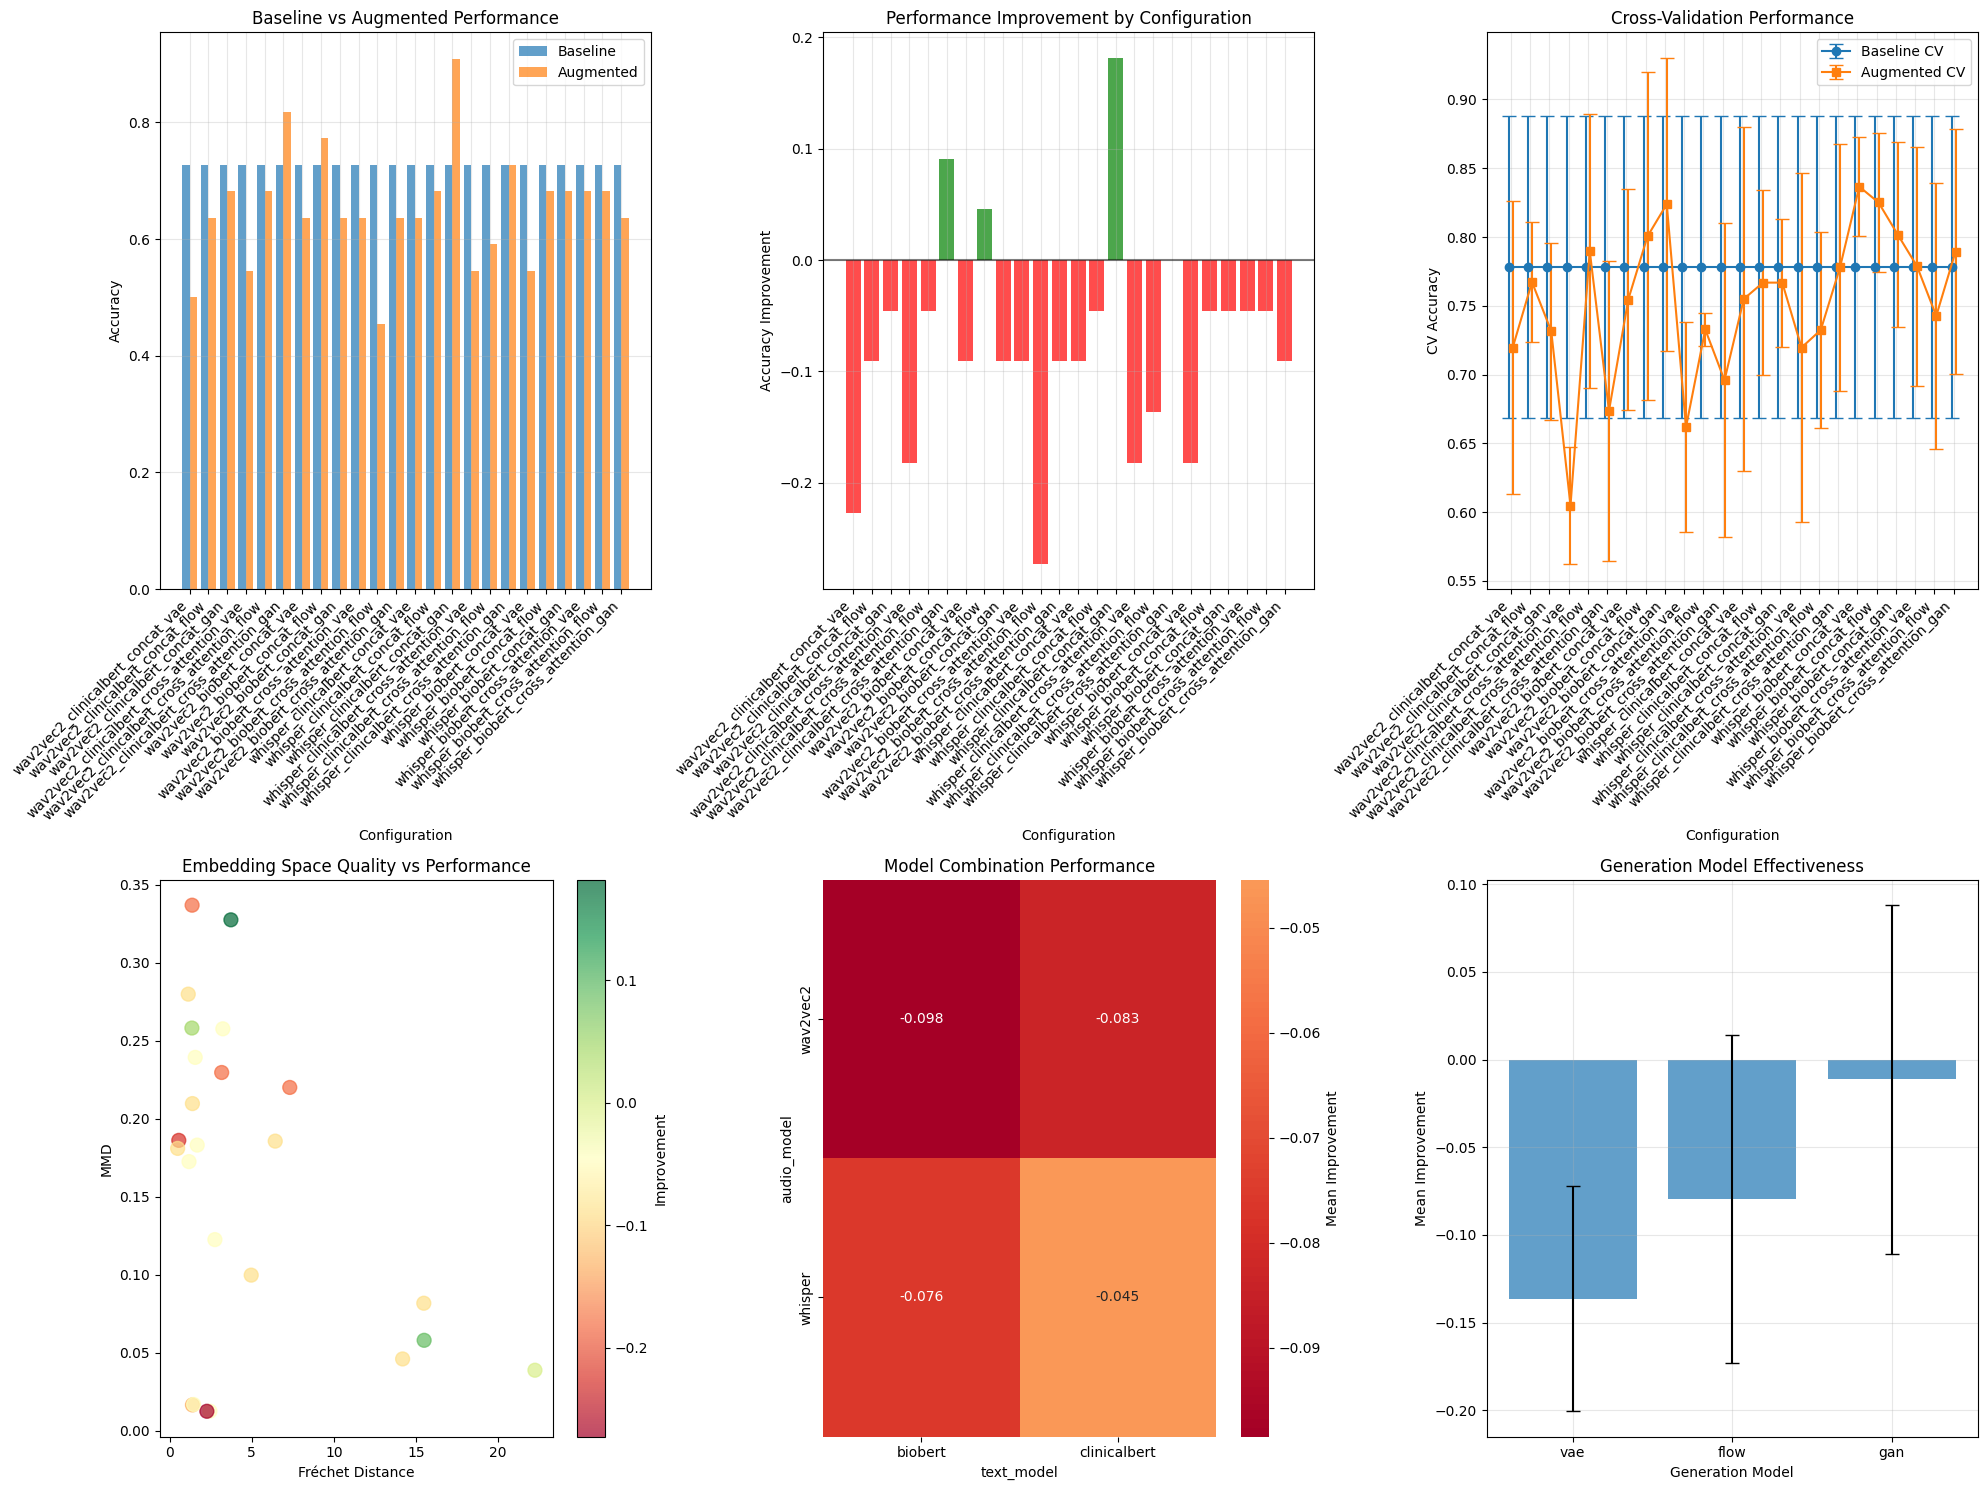

\nBest Configuration: whisper_clinicalbert_concat_gan
Improvement: 0.182
Baseline Accuracy: 0.727
Augmented Accuracy: 0.909

Complete Results Summary:
                                        config  baseline_accuracy  \
0             wav2vec2_clinicalbert_concat_vae              0.727   
1            wav2vec2_clinicalbert_concat_flow              0.727   
2             wav2vec2_clinicalbert_concat_gan              0.727   
3    wav2vec2_clinicalbert_cross_attention_vae              0.727   
4   wav2vec2_clinicalbert_cross_attention_flow              0.727   
5    wav2vec2_clinicalbert_cross_attention_gan              0.727   
6                  wav2vec2_biobert_concat_vae              0.727   
7                 wav2vec2_biobert_concat_flow              0.727   
8                  wav2vec2_biobert_concat_gan              0.727   
9         wav2vec2_biobert_cross_attention_vae              0.727   
10       wav2vec2_biobert_cross_attention_flow              0.727   
11        wav2vec2_bi

In [16]:
# Run the complete experimental pipeline
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize hyperparameters
    hyperparams = HyperparameterConfig(device=device)
    
    # Custom hyperparameters (already increased to reasonable values)
    hyperparams.update_params(
        vae_epochs=150,
        flow_epochs=120, 
        gan_epochs=200,
        svm_C=2.0,
        generation_target_count=300
    )
    
    # Load datasets
    train_loader = ADReSSDataLoader("/kaggle/input/adress/adress/train")
    test_loader = ADReSSDataLoader("/kaggle/input/adress/adress/test")
    # train_loader = ADReSSDataLoader("ADReSS-IS2020-train/ADReSS-IS2020-data/train")
    # test_loader = ADReSSDataLoader("ADReSS-IS2020-test/ADReSS-IS2020-data/test")

    # Run baseline evaluation ONCE for the simplest configuration
    print("="*60)
    print("BASELINE EVALUATION")
    print("="*60)
    
    # Create baseline embedders and fusion model 
    audio_embedder = AudioEmbedder('wav2vec2', device)
    text_embedder = TextEmbedder('clinicalbert', device)
    fusion_model = MultimodalFusion(fusion_type='concat', 
                                   output_dim=hyperparams.fusion_output_dim,
                                   num_heads=hyperparams.fusion_num_heads).to(device)
    
    # Create baseline dataset and run evaluation
    baseline_dataset = EmbeddingDataset(train_loader, audio_embedder, text_embedder, fusion_model)
    baseline_results = baseline_evaluation(baseline_dataset, hyperparams)
    
    print(f"Baseline Accuracy: {baseline_results['accuracy']:.3f}")
    print(f"Baseline F1: {baseline_results['f1_score']:.3f}")
    print(f"Baseline CV: {baseline_results['cv_mean']:.3f} ± {baseline_results['cv_std']:.3f}")
    
    # Generate baseline test predictions
    baseline_test_results = generate_test_results(
        test_loader, audio_embedder, text_embedder, fusion_model,
        baseline_results['model'], baseline_results['scaler'], 'baseline'
    )
    
    print("="*60)
    print("AUGMENTATION EXPERIMENTS")
    print("="*60)
    
    results = []
    
    # Define all possible combinations
    audio_models = ['wav2vec2', 'whisper']
    text_models = ['clinicalbert', 'biobert']
    fusion_types = ['concat', 'cross_attention']
    generation_models = ['vae', 'flow', 'gan']
    
    # Run all pipeline combinations
    total_combinations = len(audio_models) * len(text_models) * len(fusion_types) * len(generation_models)
    current_combo = 0
    
    for audio_model in audio_models:
        for text_model in text_models:
            for fusion_type in fusion_types:
                for generation_model in generation_models:
                    current_combo += 1
                    print(f"\nRunning combination {current_combo}/{total_combinations}: {audio_model}-{text_model}-{fusion_type}-{generation_model}")
                    
                    result = run_pipeline(
                        train_loader, test_loader, baseline_results,
                        audio_model, text_model, fusion_type, generation_model,
                        hyperparams, device
                    )
                    results.append(result)
    
    print("="*60)
    print("RESULTS ANALYSIS")
    print("="*60)
    
    # Convert results to DataFrame and save
    results_df = pd.DataFrame(results)
    results_df.to_csv('adress_augmentation_results.csv', index=False)
    
    # Create visualizations for complete results
    fig = create_visualizations(results_df)
    
    # Display summary statistics
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print("\nComplete Results Summary:")
    print(results_df[['config', 'baseline_accuracy', 'augmented_accuracy', 'improvement']].round(3))
    
    print("\nHyperparameter Configuration:")
    print(f"VAE: latent_dim={hyperparams.vae_latent_dim}, beta={hyperparams.vae_beta}, epochs={hyperparams.vae_epochs}")
    print(f"Flow: layers={hyperparams.flow_num_layers}, epochs={hyperparams.flow_epochs}")
    print(f"GAN: latent_dim={hyperparams.gan_latent_dim}, epochs={hyperparams.gan_epochs}, lr_g={hyperparams.gan_lr_g}")
    print(f"SVM: kernel={hyperparams.svm_kernel}, C={hyperparams.svm_C}")
    print(f"Generation: target_count={hyperparams.generation_target_count}")
    
    print(f"\nTotal combinations tested: {len(results_df)}")